캐글에서 [야생동물 충돌로 인한 비행기 사고](https://www.kaggle.com/faa/wildlife-strikes) 데이터셋을 실습용으로 다듬은 데이터.

In [5]:
%config InlineBackend.figure_format = 'retina'
!pip install matplotlib pandas plotnine statsmodels --upgrade > /dev/null

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from plotnine import *
from plotnine import options as opt

src = pd.read_csv(
    "https://s3.ap-northeast-2.amazonaws.com/data10902/messy/aircraft-strikes.csv",
    dtype={
        "record_id": np.int32,
        "year": np.int32,
        "month": np.int32,
        "day": np.int32,
        "operator_id": str,
        "operator": str,
        "aircraft": str,
        "species": str,
        "aircraft_damage": bool,
        "height": np.float32,
        "speed": np.float32,
    }
)

지정된 경로를 찾을 수 없습니다.


실수에 대비한 사본 만들기.

In [2]:
df = src.copy()

데이터 설명:

* record_id: 고유 번호
* year, month, day: 사고 발생일
* operator_id: 운영사(항공사?) 식별코드
* operator: 운영사 이름
* aircraft: 비행기 기종
* species: 야생동물종
* aircraft_damage: 항공기 손상 여부
* height: 고도
* speed: 속도

In [0]:
df.tail()

,record_id,year,month,day,operator_id,operator,aircraft,species,aircraft_damage,height,speed
174098,365837,2015,9,30,FDX,FEDEX EXPRESS,DC-10-10,UNKNOWN SMALL BIRD,False,2000.0,210.0
174099,366091,2015,9,30,SWA,SOUTHWEST AIRLINES,B-737-700,UNKNOWN SMALL BIRD,False,NaN,NaN
174100,365902,2015,9,30,SWA,SOUTHWEST AIRLINES,B-737-700,UNKNOWN SMALL BIRD,False,5000.0,250.0
174101,365903,2015,9,30,BUS,BUSINESS,CITATIONJET,TURKEY VULTURE,True,3000.0,200.0
174102,366046,2015,9,30,QXE,HORIZON AIR,DHC8 DASH 8,HERMIT THRUSH,False,6000.0,NaN


## 데이터 살펴보기

일단 연도에 따라 사고 발생 건수의 추이를 살펴보자. 사고가 늘고 있을까, 줄고 있을까? 전체 운행 건수와 비교해보면 더 의미가 있겠지만 일단 이거라도 보자.

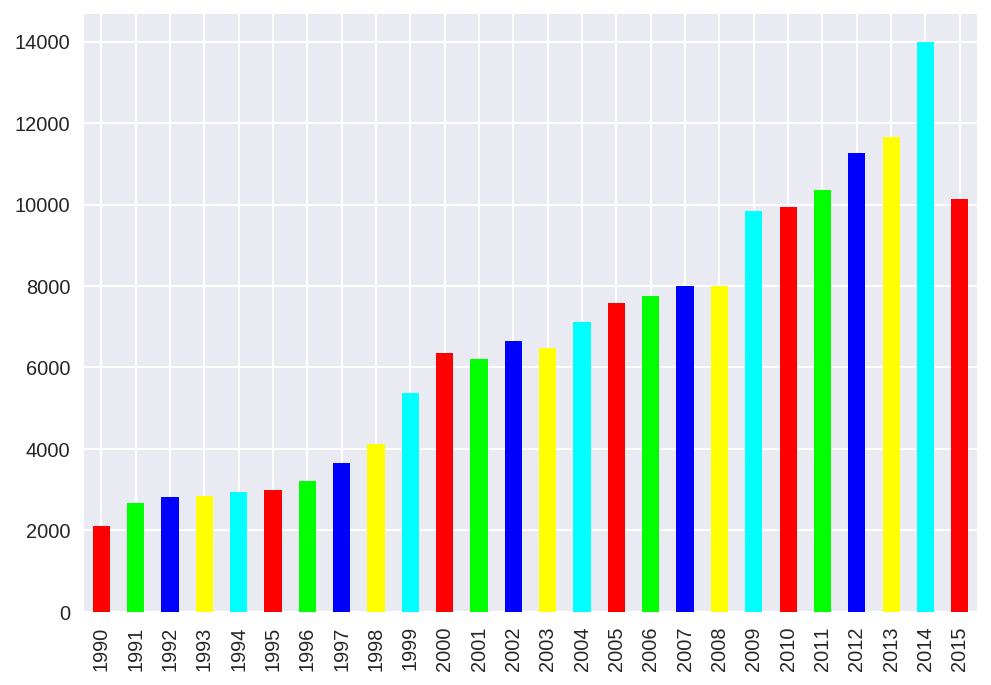

In [0]:
color=["#FF0000", "#00FF00", "#0000FF", "#FFFF00", "#00FFFF"] * 20
df["year"].value_counts().sort_index().plot.bar(color=color);

연중 사고가 가장 빈번한 달은?

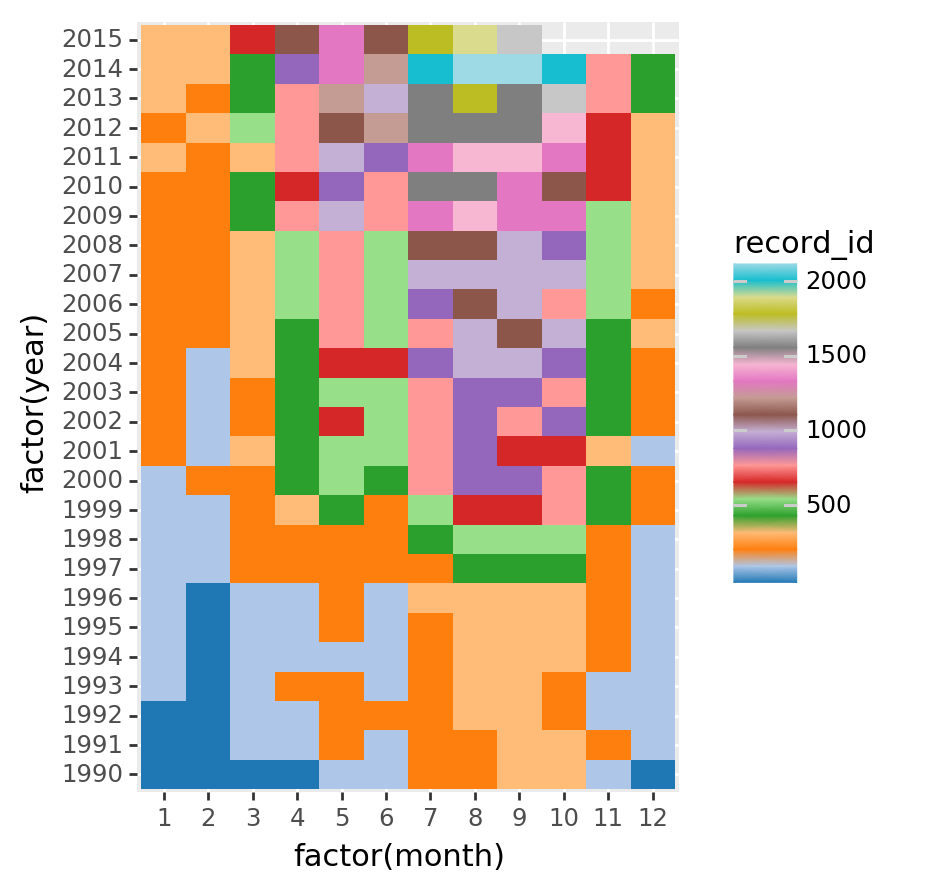

<ggplot: (-9223363285205025066)>

In [0]:
year_month = df.groupby(by=["year", "month"])["record_id"] \
  .aggregate(lambda x: x.value_counts().count()) \
  .reset_index()

(ggplot(year_month, aes('factor(month)', 'factor(year)', fill='record_id'))
 + geom_tile(aes(width=1, height=1))
 + theme(figure_size=(3.5, 5))
 + scale_fill_cmap("tab20")
)

대충 시간의 흐름에 따른 패턴에 대해서 살펴보고 났더니 그 다음으로는 인명 피해가 얼마나 클지가 궁금해진다. 기체 손상이 없었다면(aircraft_damage) 아마도 인명 피해가 없었을 것이라고 생각해도 좋지 않을까?


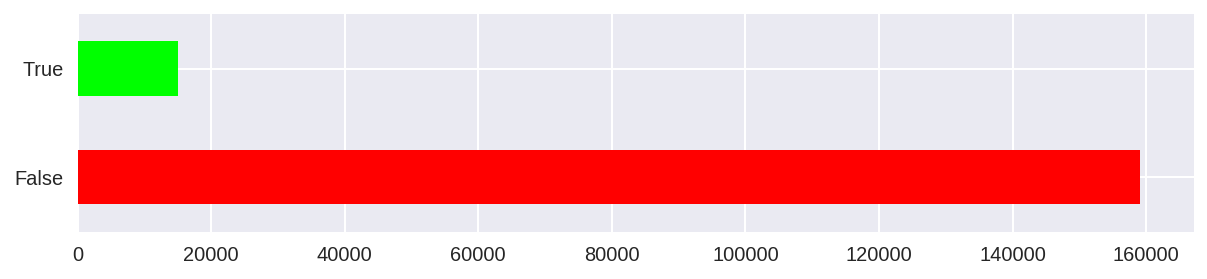

In [0]:
color=["#FF0000", "#00FF00", "#0000FF", "#FFFF00", "#00FFFF"] * 20
df["aircraft_damage"].value_counts().plot.barh(figsize=(10, 2), color=color);

## 어떤 동물들이 사고를 많이 당할까?

다행스럽게도 기체손상이 없는 경우가 열 배나 많다. 이제는 동물들이 걱정되기 시작했다.

가장 빈번하게 사고를 일으키는 야생동물종은?

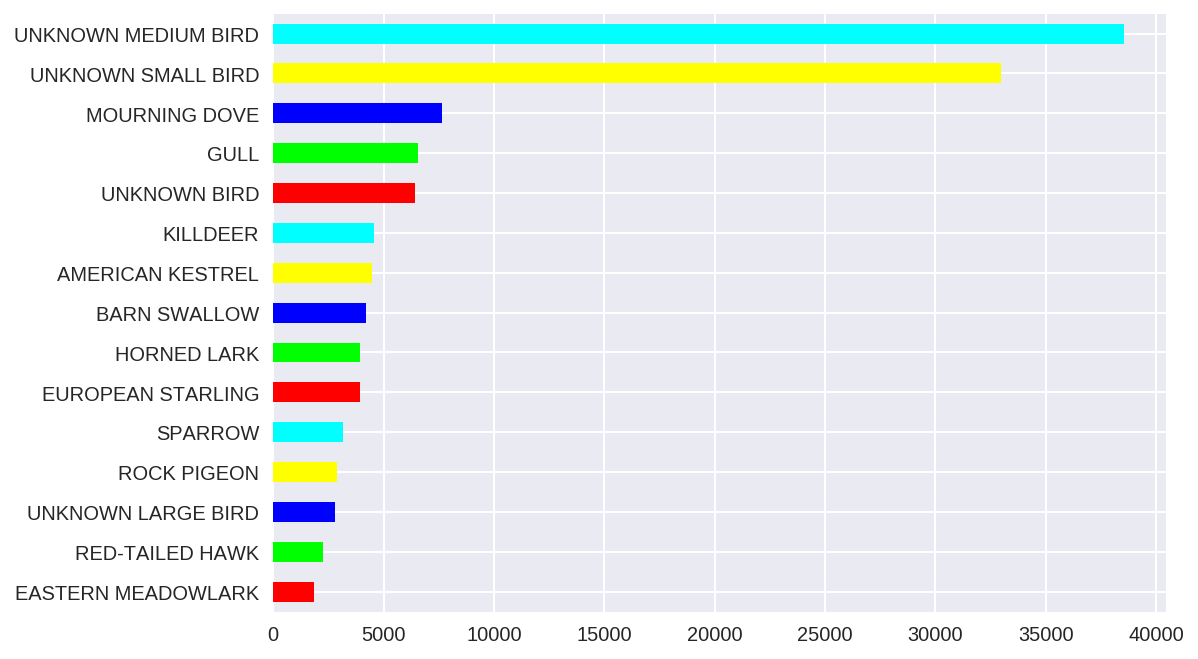

In [0]:
top_species = df["species"].value_counts().sort_values()

color=["#FF0000", "#00FF00", "#0000FF", "#FFFF00", "#00FFFF"] * 20
top_species.tail(15).plot.barh(color=color);

이륙 전(height == 0)에 발생한 사고만 보면?

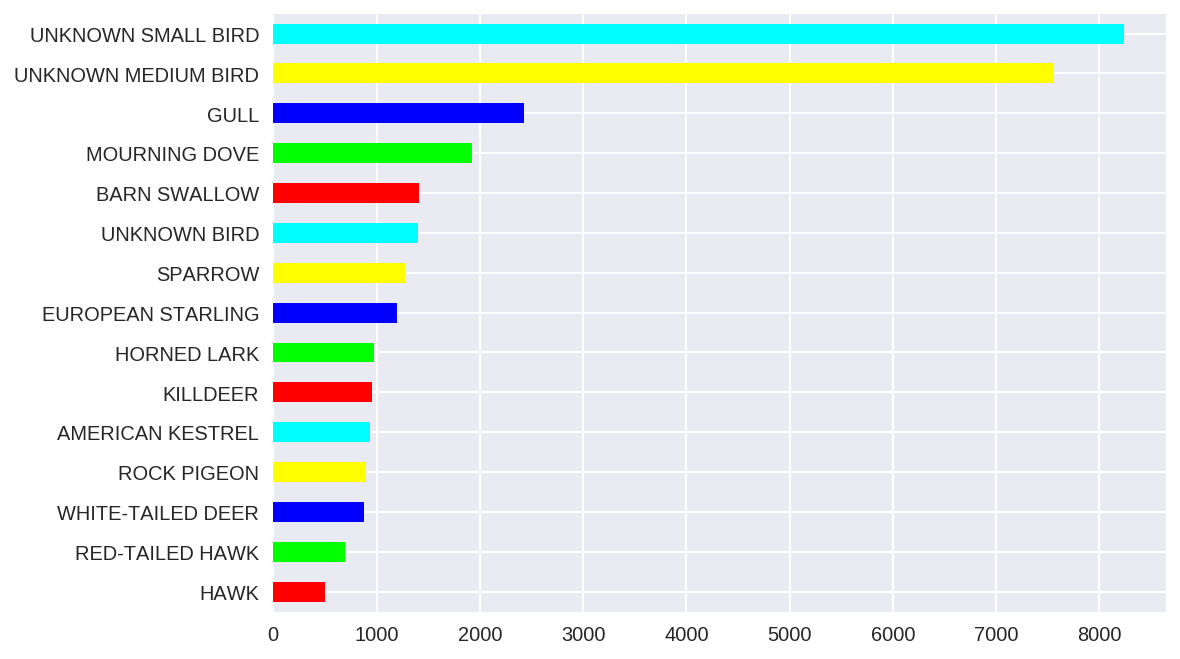

In [0]:
color=["#FF0000", "#00FF00", "#0000FF", "#FFFF00", "#00FFFF"] * 20
df.loc[df.height == 0, "species"].value_counts().sort_values().tail(15).plot.barh(color=color);

사고 당시 평균 고도를 종별로 나눠서 살펴보면 어떤 결과가 나올까?

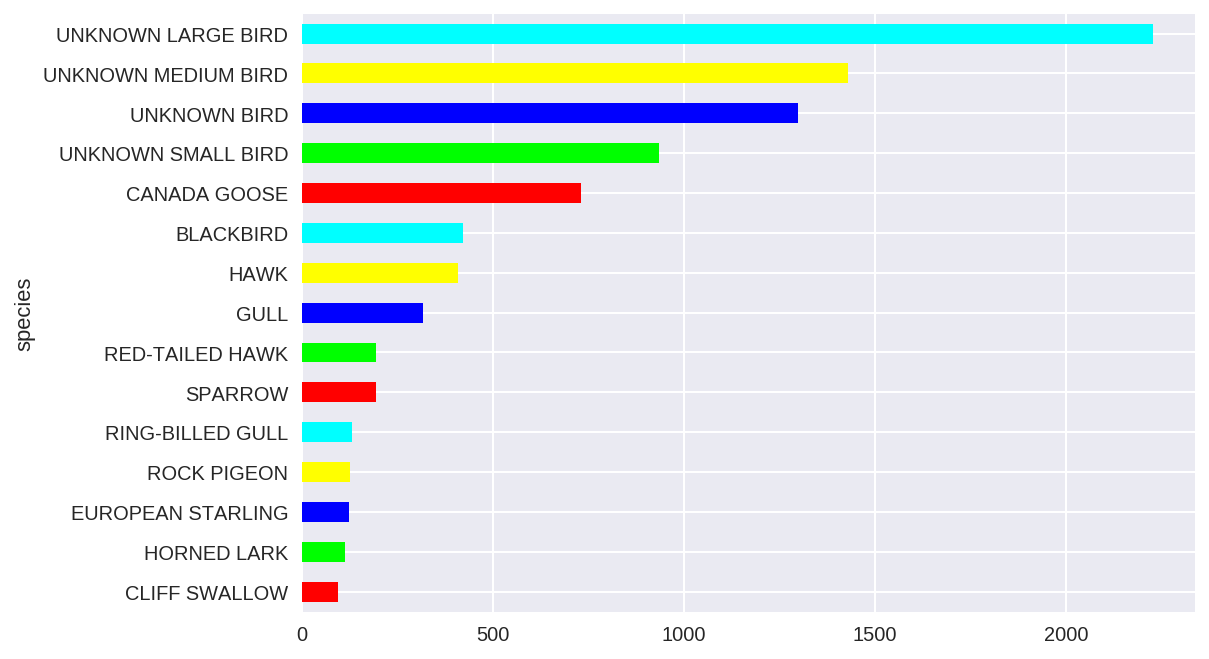

In [0]:
color=["#FF0000", "#00FF00", "#0000FF", "#FFFF00", "#00FFFF"] * 20

df.loc[df["species"].isin(top_species.tail(20).index)] \
  .groupby(by="species")["height"].mean() \
  .sort_values().tail(15).plot.barh(color=color);

고도, 속도, 기체고장률 사이의 상관 관계는?

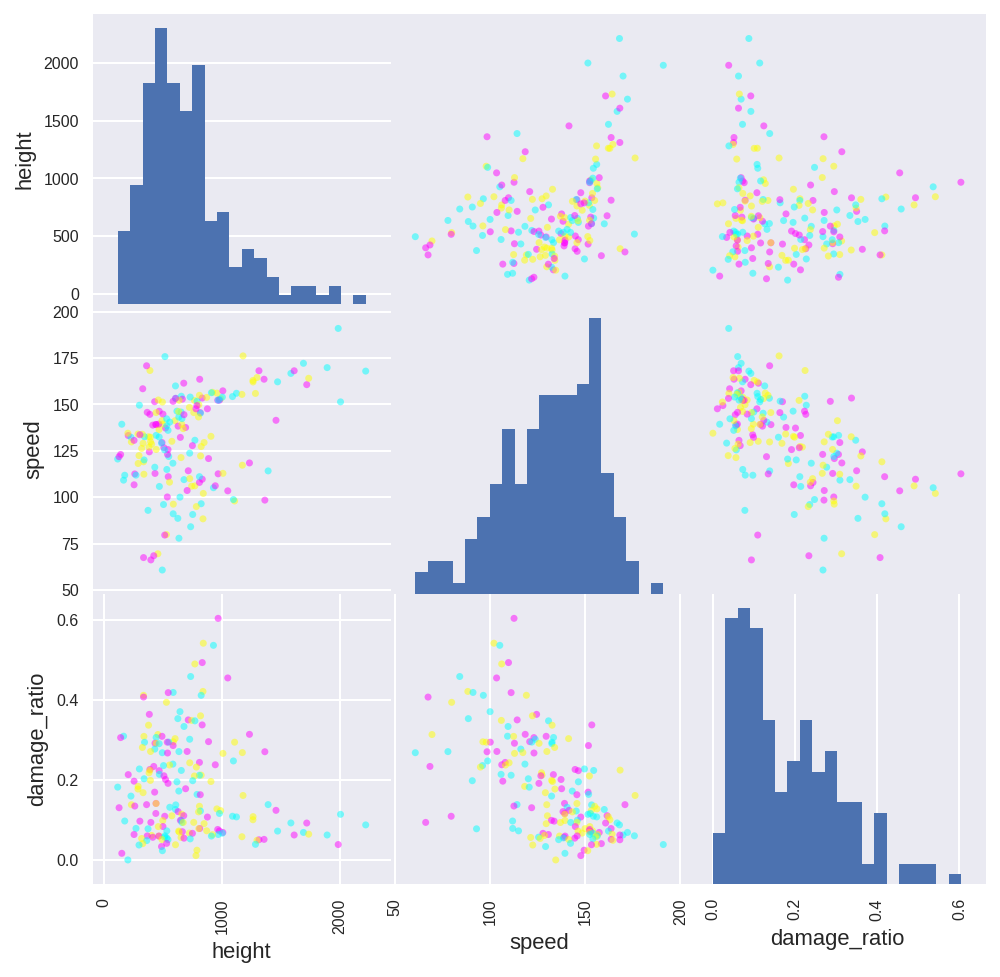

In [0]:
top_aircrafts = df["aircraft"].value_counts().sort_values()

# 기종별 사고 빈도, 평균 고도, 평균 속도, 손상률
damages = df.groupby(by="aircraft")[["record_id", "aircraft_damage", "height", "speed"]].agg({
    "record_id": lambda x: len(x.unique()),
    "aircraft_damage": np.sum,
    "height": np.mean,
    "speed": np.mean,
})
damages["damage_ratio"] = damages["aircraft_damage"] / damages["record_id"]

# 사고 빈도가 50회 이상인 기종에 대한 scatter plot matrix
color=["#FF00FF", "#FFFF00", "#00FFFF"] * 20
pd.plotting.scatter_matrix(
    damages.loc[damages["record_id"] > 50, ["height", "speed", "damage_ratio"]].sort_values("damage_ratio", ascending=False),
    figsize=(8, 8),
    range_padding=0.2,
    hist_kwds={"bins": 20},
    color=color
);